In [46]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
words = open('names.txt', 'r').read().splitlines()

In [48]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

In [49]:
import random
random.seed(42)
random.shuffle(words)

In [50]:
#build the dataset

block_size = 8 #context size

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #update context

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [51]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [52]:
from typing import Any


class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1D:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #params trained with backpropagation
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers trained with running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        #forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) #batch mean
            xvar = x.var(dim, keepdim=True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) #normalize to unit variance
        self.out = self.gamma + xhat + self.beta

        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive: #flattens n consecutive elements and puts them to last dim
    def __init__(self,n):
        self.n = n
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [53]:
torch.manual_seed(42)

In [54]:
n_embd = 24 #the dimensionality of the char embedding 
n_hidden = 128 # number of neurons in the hidden layer


model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    #make last layer less confident
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # tot number of parameters

for p in parameters:
    p.requires_grad = True

76579


In [41]:
#example with 4 batches
'''
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(f'Input dim: {Xb.shape}')
'''
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))


Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1D : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1D : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1D : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


In [39]:
e = torch.randn(4,8,10) #we want to concatenate consecutive 10-d vectors. This will become (4,4,20)
explicit_concat = torch.cat([e[:, ::2, :], e[:,1::2,:]], dim=2) #concatenates every consec(even|odd) along 2nd dimension
concat = e.view(4, 4, 20) #same as the line above
concat.shape
#we now implement into flatten layer object

torch.Size([4, 4, 20])

In [55]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3104
  10000/ 200000: 2.0299
  20000/ 200000: 1.9673
  30000/ 200000: 2.5938
  40000/ 200000: 2.1035
  50000/ 200000: 1.8125
  60000/ 200000: 2.1614
  70000/ 200000: 1.8754
  80000/ 200000: 1.7399
  90000/ 200000: 2.0656
 100000/ 200000: 1.7476
 110000/ 200000: 2.0210
 120000/ 200000: 1.6565
 130000/ 200000: 1.8619
 140000/ 200000: 1.7176
 150000/ 200000: 1.7910
 160000/ 200000: 1.7216
 170000/ 200000: 1.5698
 180000/ 200000: 1.6600
 190000/ 200000: 1.9359


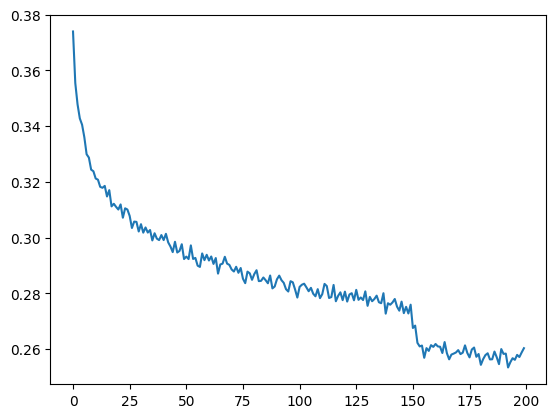

In [56]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [57]:
for layer in model.layers:
  layer.training = False

In [58]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits,y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.778014898300171
val 1.981567621231079


In [59]:
#Sampling from the model

for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples = 1).item()

        context = context[1:] + [ix]

        if ix == 0:
           break
        
        out.append(ix)

    print(''.join(itos[i] for i in out))

aiyanah
giusop
jensen
saba
raynor
francielle
yochimce
candalphond
laylar
sharla
jaice
mynder
daxton
monterric
shildew
cosmauri
kiever
jawson
nikoline
naria
